In [1]:
!pip install gymnasium[atari]
!pip install ale-py
!pip install autorom[accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.1
    Uninstalling ale-py-0.11.1:
      Successfully uninstalled ale-py-0.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.17.6 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 21.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements 

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os

import gymnasium as gym
import ale_py
import gymnasium.wrappers as gym_wrap

In [ ]:
import torch
import torch.nn as nn
from torch import optim

import gymnasium as gym


In [ ]:
class DQN(nn.Module):

    def __init__(self, states_shape, n_actions):
        super().__init__()
        c, w, h = states_shape
        self.n_actions = n_actions
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 2)


        self.features = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size = 8, stride = 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1),
            nn.ReLU()
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, c, h, w)
            n_flatten = self.features(dummy_input).view(1, -1).size(1)


        self.values = nn.Sequential(
            nn.Linear(n_flatten, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_actions)
        )


    def forward(self, states):
        # print(states.shape)
        features = self.features(states)
        features = torch.flatten(features, start_dim=1)
        # print(features.shape)
        value = self.values(features)
        
        return value
        

In [ ]:
class ReplayBuffer:
    def __init__(self, size=60000, state_shape=(4, 84, 84)):
        self.size = size
        self.path = "/kaggle/working/data"
        self.state_shape = state_shape
        os.makedirs(self.path, exist_ok=True)

        self.states = np.memmap(f"{self.path}/states.dat", dtype=np.float32, mode="w+", shape=(size, *state_shape))
        self.actions = np.memmap(f"{self.path}/actions.dat", dtype=np.int64, mode="w+", shape=(size, ))
        self.rewards = np.memmap(f"{self.path}/rewards.dat", dtype=np.float32, mode="w+", shape=(size,))
        self.next_states = np.memmap(f"{self.path}/next_states.dat", dtype=np.float32, mode="w+", shape=(size, *state_shape))
        self.dones = np.memmap(f"{self.path}/dones.dat", dtype=np.int8, mode="w+", shape=(size,))

        self.ptr = 0
        self.full = False

    def __len__(self):
        return self.size if self.full else self.ptr

    # def preprocess(self, frame):

    #     frame = np.array(frame)
    #     obs = frame[:, 34:-16, :]
    #     obs = obs.transpose(1, 2, 0)
    #     obs = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_AREA)
    #     obs = obs.transpose(2, 0, 1)
    #     # print(ob?s.shape)
    #     return obs/255.0

    def add(self, state, action, reward, next_state, done):
        self.states[self.ptr] = np.array(state, np.float32)/255.0
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = np.array(next_state)/255.0
        self.dones[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.size
        if self.ptr == 0:
            self.full = True

    def sample(self, batch_size):
        max_size = len(self)
        idx = np.random.randint(0, max_size, size=batch_size)

        batch_states = self.states[idx]
        batch_actions = self.actions[idx]
        batch_rewards = self.rewards[idx]
        batch_next_states = self.next_states[idx]
        batch_dones = self.dones[idx]

        return (batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)


In [ ]:
class Agent:

    def __init__(self,env, states_shape, n_actions, gamma=0.9, episilon = 1, episilon_decay = 0.999999, episilon_min = 0.01, checkpoint = None):
        
        self.env = env
        self.n_actions = n_actions
        
        self.gamma = gamma
        self.episilon = episilon
        self.episilon_decay = episilon_decay
        self.episilon_min = episilon_min
        self.steps = 0
        self.target_update_freq = 1000
        self.batch_size = 32
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(states_shape, n_actions)
        self.target_net = DQN(states_shape, n_actions)
        self.buffer = ReplayBuffer()
        
        self.policy_net.to(self.device)
        self.target_net.to(self.device)

        self.rewards_per_episode = []
        self.loss_per_episode = []

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = 0.00001)
        
        if checkpoint:
            self.policy_net.load_state_dict(checkpoint['model_state_dict'])
            self.episilon = checkpoint['epsilon']
            self.steps = checkpoint['steps']
            # self.buffer = checkpoint['buffer']
            self.rewards_per_episode = checkpoint['rewards']
            self.loss_per_episode = checkpoint['loss']
            self.optimizer.load_state_dict(checkpoint['optimizer_state'])
            
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.loss = nn.SmoothL1Loss()
        self.addMemory()
        
    
    def addMemory(self):
        state = self.env.reset()[0]
        state = self.skipFrame()
        for _ in range(40000):

            action = self.env.action_space.sample()
            next_state, reward, term, trun, _ = self.env.step(action)
            done = int(term or trun)
            self.buffer.add(state, action, reward, next_state, done)
            if done:
                state = self.env.reset()[0]
                state = self.skipFrame()
            else:
                state = next_state

    def skipFrame(self):
        for i in range(16):
            obss = self.env.step(self.env.action_space.sample())
        return obss[0]
        
    def select_action(self, state):
        if random.random() < self.episilon:
            return self.env.action_space.sample()

        state = np.array(state, np.float32) / 255.0
        state = torch.Tensor(np.array(state)).unsqueeze(0).to(self.device)
        with torch.no_grad():
            qValues = self.policy_net(state)
        return torch.argmax(qValues).item()


    def train(self):
        
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, done = self.buffer.sample(self.batch_size)
        states = torch.tensor(np.array(states), dtype = torch.float32).to(self.device)
        actions = torch.tensor(np.array(actions)).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.tensor(np.array(next_states), dtype = torch.float32).to(self.device)
        done = torch.tensor(done).unsqueeze(1).to(self.device)

        # print(states.shape, actions.shape)
        qValue = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target_qValues = rewards + self.gamma * next_q_values * (1 - done)
                
        loss = self.loss(qValue, target_qValues)
        self.loss_value += loss.item()
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.episilon = max(self.episilon_min, self.episilon_decay * self.episilon)
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())



    def playingLoop(self, num_episodes = 500):
        self.num_episodes = num_episodes


        for ep in range(num_episodes):
            self.loss_value = 0
            state = self.env.reset()[0]
            state = self.skipFrame()
            
            # print(state.shape)
            episode_reward = 0
            done = 0

            while not done:

                action = self.select_action(state)
                next_state, reward, term, trun, _ = self.env.step(action)
                done = int(term or trun)
                self.buffer.add(state, action, reward, next_state, done)
                self.train()
                state = next_state
                episode_reward += reward

            self.rewards_per_episode.append(episode_reward)
            self.loss_per_episode.append(self.loss_value)

            if (ep) % 10 == 0:
                torch.save(self.policy_net.state_dict(), f"carAgent{ep}.pth")
                print("Model saved")
            avg_reward = np.mean(self.rewards_per_episode[-10:])
            print(f"Episode {ep} | Avg Reward: {avg_reward:.2f} | Current Reward : {episode_reward:.2f} | Epsilon: {self.episilon:.2f}")
            
            
            if (ep+1)%100 == 0:
                checkpoint = {
                    'episodes': len(self.loss_per_episode),
                    'steps' : self.steps,
                    # 'buffer' : self.buffer,
                    'epsilon' : self.episilon,
                    'model_state_dict': self.policy_net.state_dict(),
                    'optimizer_state' : self.optimizer.state_dict(),
                    'loss': self.loss_per_episode,
                    'rewards' : self.rewards_per_episode
                }
                torch.save(checkpoint, 'checkpoint.pth')
                print("Hit Checkpoint!!")

    
    def plot(self, interval = 50):
        moving_average = np.convolve(self.rewards_per_episode, np.ones(interval)/interval, mode = "same")
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(len(self.rewards_per_episode)), self.rewards_per_episode, label = "Actual Reward")
        plt.plot(range(len(self.rewards_per_episode)), moving_average, label = "Average Reward")
        plt.title("Rewards per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Reward")

        moving_average_loss = np.convolve(self.loss_per_episode, np.ones(interval)/interval, mode = "same")
        plt.subplot(1, 2, 2)
        plt.plot(range(len(self.rewards_per_episode)), self.loss_per_episode, label = "Actual Loss")
        plt.plot(range(len(self.rewards_per_episode)), moving_average_loss, label = "Average Loss")
        plt.title("Training Loss")
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.tight_layout()
        plt.legend()
        plt.savefig("plot.png")
        plt.show()


In [8]:
class Cropp(gym.ObservationWrapper):

    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(160,160), dtype=np.uint8)
        
        
    def observation(self, obs):
        return obs[34:-16 , :]

In [ ]:
episodes = 1500
env = gym.make('ALE/Pong-v5', render_mode='rgb_array')

env = gym_wrap.GrayScaleObservation(env)
env = Cropp(env)
env = gym_wrap.ResizeObservation(env, shape=84)
env = gym_wrap.FrameStack(env, num_stack=4)

agent = Agent(env, (4, 84, 84), env.action_space.n)
agent.playingLoop(episodes)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Model saved
Episode 0 | Avg Reward: -19.00 | Current Reward : -19.00 | Epsilon: 1.00
Episode 1 | Avg Reward: -20.00 | Current Reward : -21.00 | Epsilon: 1.00
Episode 2 | Avg Reward: -20.00 | Current Reward : -20.00 | Epsilon: 1.00
Episode 3 | Avg Reward: -20.25 | Current Reward : -21.00 | Epsilon: 1.00
Episode 4 | Avg Reward: -20.20 | Current Reward : -20.00 | Epsilon: 1.00
Episode 5 | Avg Reward: -20.33 | Current Reward : -21.00 | Epsilon: 0.99
Episode 6 | Avg Reward: -20.43 | Current Reward : -21.00 | Epsilon: 0.99
Episode 7 | Avg Reward: -20.50 | Current Reward : -21.00 | Epsilon: 0.99
Episode 8 | Avg Reward: -20.56 | Current Reward : -21.00 | Epsilon: 0.99
Episode 9 | Avg Reward: -20.40 | Current Reward : -19.00 | Epsilon: 0.99
Model saved
Episode 10 | Avg Reward: -20.60 | Current Reward : -21.00 | Epsilon: 0.99
Episode 11 | Avg Reward: -20.50 | Current Reward : -20.00 | Epsilon: 0.99
Episode 12 | Avg Reward: -20.50 | Current Reward : -20.00 | Epsilon: 0.99
Episode 13 | Avg Reward:

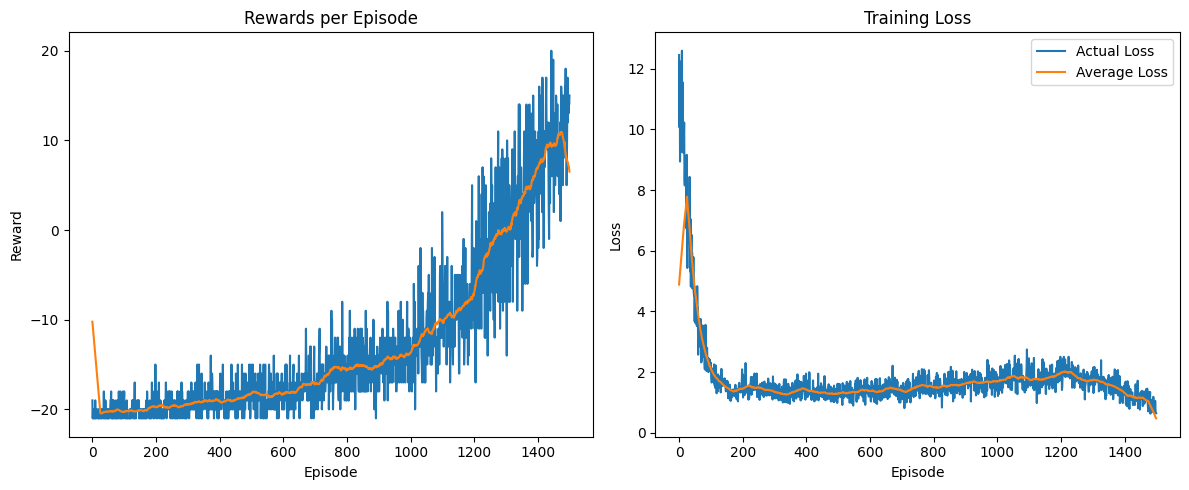

In [10]:
agent.plot()

In [ ]:
checkpoint = torch.load('/kaggle/input/checkpoint1500/pytorch/default/1/checkpoint1500.pth', map_location = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

episodes = 1200
env = gym.make('ALE/Pong-v5', render_mode='rgb_array')


env = gym_wrap.GrayScaleObservation(env)
env = Cropp(env)
env = gym_wrap.ResizeObservation(env, shape=84)
env = gym_wrap.FrameStack(env, num_stack=4)

agent = Agent(env, (4, 84, 84), env.action_space.n, checkpoint = checkpoint)
agent.playingLoop(episodes)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Model saved
Episode 0 | Avg Reward: 13.10 | Current Reward : 9.00 | Epsilon: 0.04
Episode 1 | Avg Reward: 13.10 | Current Reward : 8.00 | Epsilon: 0.04
Episode 2 | Avg Reward: 11.90 | Current Reward : 1.00 | Epsilon: 0.04
Episode 3 | Avg Reward: 10.70 | Current Reward : 5.00 | Epsilon: 0.04
Episode 4 | Avg Reward: 9.70 | Current Reward : 2.00 | Epsilon: 0.04
Episode 5 | Avg Reward: 8.70 | Current Reward : 5.00 | Epsilon: 0.04
Episode 6 | Avg Reward: 7.80 | Current Reward : 4.00 | Epsilon: 0.04
Episode 7 | Avg Reward: 6.60 | Current Reward : 3.00 | Epsilon: 0.04
Episode 8 | Avg Reward: 5.70 | Current Reward : 5.00 | Epsilon: 0.04
Episode 9 | Avg Reward: 4.70 | Current Reward : 5.00 | Epsilon: 0.04
Model saved
Episode 10 | Avg Reward: 5.00 | Current Reward : 12.00 | Epsilon: 0.04
Episode 11 | Avg Reward: 5.10 | Current Reward : 9.00 | Epsilon: 0.04
Episode 12 | Avg Reward: 5.30 | Current Reward : 3.00 | Epsilon: 0.04
Episode 13 | Avg Reward: 5.60 | Current Reward : 8.00 | Epsilon: 0.04
E

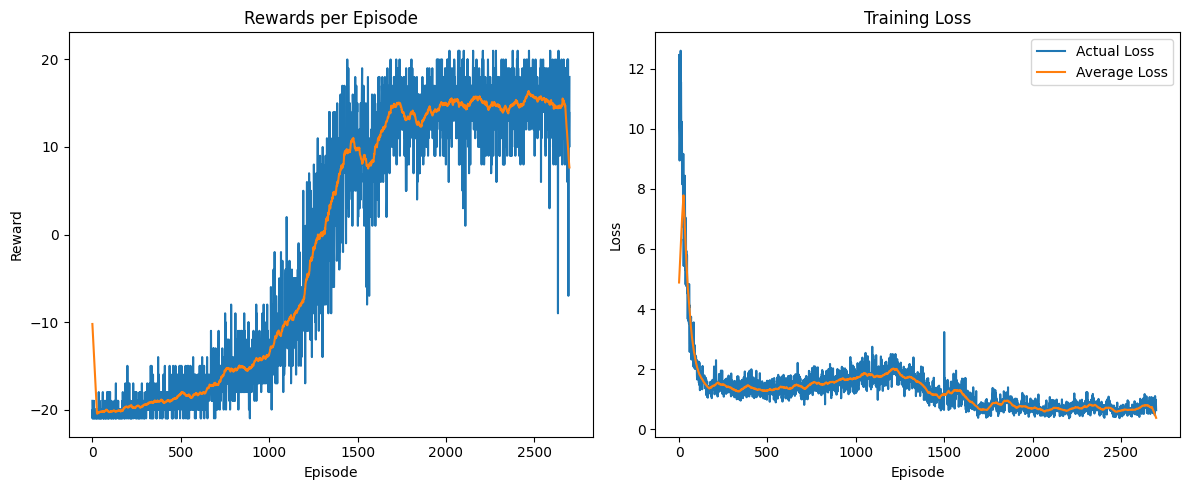

In [10]:
agent.plot()